---

## Khmer Sentiment Analysis with BERT Fine-Tuning Based Approach
---

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys
sys.path.append("/content/drive/bert_khmer")

In [ ]:
import re
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

In [ ]:
import tokenization_km
import modeling
import optimization
import run_classifier

In [ ]:
OUTPUT_DIR = "/content/fine_tuned_model"

### Load Pre-trained BERT module for khmer

In [ ]:
!unzip "/content/drive/bert_module_khmer.zip" -d "./pretrained"

Archive:  /content/drive/My Drive/Colab Notebooks/Khmer Paper/bert_module_khmer.zip
   creating: ./pretrained/bert_module_khmer/
   creating: ./pretrained/bert_module_khmer/assets/
  inflating: ./pretrained/bert_module_khmer/assets/bert_config.json  
  inflating: ./pretrained/bert_module_khmer/assets/vocab_file_BERT_.txt  
  inflating: ./pretrained/bert_module_khmer/saved_model.pb  
  inflating: ./pretrained/bert_module_khmer/tfhub_module.pb  
   creating: ./pretrained/bert_module_khmer/variables/
  inflating: ./pretrained/bert_module_khmer/variables/variables.data-00000-of-00001  
  inflating: ./pretrained/bert_module_khmer/variables/variables.index  


### Load Train/Validation Data

In [ ]:
data = pd.read_excel("/content/drive/sentiment_analysis_data_km.xlsx", encoding="UTF-8")

### Preprocessing

In [ ]:
data['text_prep'] = data['text_prep'].apply(lambda x: ' '.join(re.sub(r'[០១២៣៤៥៦៧៨៩។៕៖ៗ៘៙៚]+', ' ', x).strip().split()))

In [ ]:
data.drop_duplicates(subset=['text_prep'], inplace=True)

In [ ]:
data.head(3)

,source,texts,texts_km,text_prep,sentiment
0,Yelp,Wow... Loved this place.,អីយ៉ា ... ស្រឡាញ់កន្លែងនេះ។,អីយ៉ា ស្រឡាញ់ កន្លែង នេះ,1
1,Yelp,Crust is not good.,សំបកគឺជាការមិនល្អ។,សំបក គឺ ជា ការ មិន ល្អ,0
2,Yelp,Not tasty and the texture was just nasty.,មិនហ៊ាននិងវាយនភាពនេះគឺអាក្រក់គ្រាន់តែជា។,មិន ហ៊ាន និង វាយន ភាព នេះ គឺ អាក្រក់ គ្រាន់ តែ ជា,0


In [ ]:
data.shape

(10710, 5)

In [ ]:
data['sentiment'].value_counts()

1    5367
0    5343
Name: sentiment, dtype: int64

### Data Partitioning

In [ ]:
X = data['text_prep']
y = data['sentiment']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1234, shuffle=True, stratify=y)

print("""Training shape: {}
Validation shape: {}""".format(X_train.shape[0], X_val.shape[0]))

Training shape: 8568
Validation shape: 2142


In [ ]:
train = pd.DataFrame({'text': X_train, 'sentiment': y_train})
val = pd.DataFrame({'text': X_val, 'sentiment': y_val})

### Creat Input Example

In [ ]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'sentiment'

train_InputExamples = train.apply(lambda x: run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val.apply(lambda x: run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

### Tokenizer

In [ ]:
vocab_path = '/content/pretrained/bert_module_khmer/assets/vocab_file_BERT_.txt'
tokenizer = tokenization_km.FullTokenizer(vocab_file=vocab_path, do_lower_case=True)

### Feature Extraction

In [ ]:
MAX_SEQ_LENGTH = 128
label_list = [0, 1]
train_features = run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
val_features = run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)


INFO:tensorflow:Writing example 0 of 8568
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: None
INFO:tensorflow:tokens: [CLS] សាឡាត់ របស់ ខ្ញុំ មាន សុផា លើ បៃតង ហើយ ចិត្ត នៃ ទារក ដូង [SEP]
INFO:tensorflow:input_ids: 0 111495 97489 7554 2113 97806 20394 27408 130476 47229 72073 50585 148893 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

### Create Classification Model

In [ ]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels, num_labels):
  """Creates a classification model."""

  bert_module = hub.Module("./pretrained/bert_module_khmer/", trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.0))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

### Creating Model Function

In [ ]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps, num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        return {
            "eval_accuracy": accuracy
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [ ]:
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 2.0
WARMUP_PROPORTION = 0.6
SAVE_CHECKPOINTS_STEPS = int(len(train_features) / BATCH_SIZE)
SAVE_SUMMARY_STEPS = 100

In [ ]:
# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [ ]:
# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    keep_checkpoint_max = 8)

In [ ]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': '/content/fine_tuned_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 267, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 8, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f52a0cfac18>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

### Training

In [ ]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
INFO:tensorflow:Skipping training since max_steps has already saved.
Training took time  0:00:00.018864


### Training Accuracy

In [ ]:
test_input_fn_with_train_data = run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [ ]:
train_result = []
for i in [536]:
    train_acc = estimator.evaluate(input_fn=test_input_fn_with_train_data, steps=None,
                    checkpoint_path='content/fine_tuned_model/model.ckpt-' + str(i))
    train_result.append(train_acc)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-08-23T17:35:34Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from content/fine_tuned_model/model.ckpt-536
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-08-23-17:37:28
INFO:tensorflow:Saving dict for global step 536: eval_accuracy = 0.8328665, global_step = 536, loss = 0.40150547
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 536: content/fine_tuned_model/model.ckpt-536


### Validation accuracy

In [ ]:
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [ ]:
val_result = []
for i in [536]:
    val_acc = estimator.evaluate(input_fn=val_input_fn, steps=None, 
                                checkpoint_path='content/fine_tuned_model/model.ckpt-' + str(i))
    val_result.append(val_acc)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-08-23T17:38:58Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from content/fine_tuned_model/model.ckpt-536
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-08-23-17:40:04
INFO:tensorflow:Saving dict for global step 536: eval_accuracy = 0.82726425, global_step = 536, loss = 0.40080485
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 536: content/fine_tuned_model/model.ckpt-536


In [ ]:
pd.DataFrame({"Train": [i['eval_accuracy'] for i in train_result], "Validation": [i['eval_accuracy'] for i in val_result]})

,Train,Validation
0,0.832866,0.827264


### Test Accuracy

In [ ]:
# Load Test Data
data_test = pd.read_excel("/content/sentiment_analysis_test_data.xlsx")

In [ ]:
data_test['X_test'] = data_test['X_test'].apply(lambda x: ' '.join(re.sub(r'[០១២៣៤៥៦៧៨៩។៕៖ៗ៘៙៚]+', ' ', x).strip().split()))

In [ ]:
data_test.head()

,texts,X_test,y_test
0,ខ្ញុំត្រូវចាកចេញពីការងារ នឹងមិនអាចទៅរួចទេ។ ដូច...,ខ្ញុំ ត្រូវ ចាក ចេញ ពី ការងារ នឹង មិន អាច ទៅ រ...,0
1,សួស្តី។ យើងកំពុងហោះហើរ SWA ថ្ងៃនេះ។ កូនប្រុសរប...,សួស្តី យើង កំពុង ហោះ ហើរ ថ្ងៃ នេះ កូន ប្រុស រប...,0
2,សម្លៀកបំពាក់នេះមើលទៅហើយមានអារម្មណ៍ថាថោក។ សម្ភា...,សម្លៀកបំពាក់ នេះ មើល ទៅ ហើយ មាន អារម្មណ៍ ថា ថោ...,0
3,ធំពេកហើយវាមិនមានសុវត្ថិភាពគ្រប់គ្រាន់ពាក់សម្រា...,ធំ ពេក ហើយ វា មិន មាន សុវត្ថិ ភាព គ្រប់ គ្រាន់...,0
4,តើអ្នកដឹងទេនៅពេលផ្លូវថ្មីពី HOU ទៅ Aruba &amp ...,តើ អ្នក ដឹង ទេ នៅ ពេល ផ្លូវ ថ្មី ពី ទៅ នឹង អាច...,0


In [ ]:
data_test.y_test.value_counts()

0    209
1    191
Name: y_test, dtype: int64

In [ ]:
X_test, y_test = data_test.X_test, data_test.y_test

#### Prediction

In [ ]:
%%time
from sklearn.metrics import accuracy_score

y_actual = y_test.tolist()


labels = [0, 1]
pred_sentences = X_test.to_list()
input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in pred_sentences]
input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)

test_result = []
predictions = estimator.predict(predict_input_fn, 
                                checkpoint_path='content/fine_tuned_model/model.ckpt-536')
predictions = [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(pred_sentences, predictions)]
y_pred = [i[2] for i in predictions]
test_result.append(accuracy_score(y_actual, y_pred))

INFO:tensorflow:Writing example 0 of 400
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: 
INFO:tensorflow:tokens: [CLS] ខ្ញុំ ត្រូវ ចាក ចេញ ពី ការងារ នឹង មិន អាច ទៅ រួច ទេ ដូច្នេះ ខ្ញុំ ចង់ ជំនួស កន្លែង នេះ ឥឡូវ នេះ [SEP]
INFO:tensorflow:input_ids: 0 7554 74058 97588 18862 29168 155316 6654 85425 13977 127642 154738 23478 48554 7554 57123 13475 22750 28801 52480 28801 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

### Result Analysis

In [ ]:
pd.DataFrame({"Train": [i['eval_accuracy'] for i in train_result],
              "Validation": [i['eval_accuracy'] for i in val_result],
              "test": test_result[0]})

,Train,Validation,test
0,0.832866,0.827264,0.81


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
## generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
p = pd.DataFrame(cm, 
                 index = ['Negative', 'Positive'],
                 columns = ['Negative', 'Positive'])
p.style.set_properties(**{'background-color': 'skyblue', 
                          'color': 'black'})

,Negative,Positive
Negative,160,49
Positive,27,164


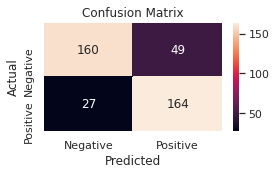

In [ ]:
## Confusion Matrix in Heatmap
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(4, 2))
sns.set()
f = sns.heatmap(p, annot=True, fmt="d")
plt.title("Confusion Matrix", fontdict={'fontsize': 12})
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# f.get_figure().savefig("sentiment_confusion_matrix_fine_tune.jpg", dpi=300, bbox_inches='tight')

In [ ]:
## Classification Report
target_names = ['Negative', 'Positive']
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

    Negative       0.86      0.77      0.81       209
    Positive       0.77      0.86      0.81       191

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400

